Train size: 4355
Test size: 1089


C:\Users\Anjali\AppData\Local\Temp\ipykernel_18260\2706760692.py:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=bin_tr, palette="coolwarm")
C:\Users\Anjali\AppData\Local\Temp\ipykernel_18260\2706760692.py:102: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=resampled_bin, palette="Spectral")


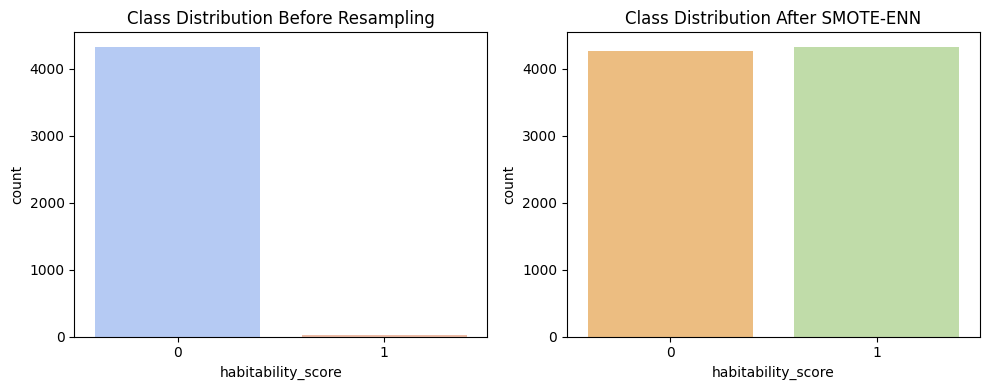

Balanced class counts: Counter({1: 4330, 0: 4262})
Preprocessing and balancing completed successfully.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.combine import SMOTEENN
from collections import Counter

# =====================================================
# STEP 1: LOAD DATA
# =====================================================
data = pd.read_csv("final-preprocessed-updated.csv")

# =====================================================
# STEP 2: REMOVE TARGET LEAKAGE & IDENTIFIERS
# =====================================================
leak_features = ['pl_rade', 'pl_insol', 'pl_eqt', 'pl_orbeccen']
meta_features = ['pl_name', 'hostname', 'st_spectype', 'discoverymethod']

target = data['habitability_score']
features = data.drop(columns=leak_features + meta_features + ['habitability_score'])

# Binary label only for stratification & balancing
binary_label = (target > 0.7).astype(int)

# =====================================================
# STEP 3: STRATIFIED SPLIT (80–20)
# =====================================================
X_tr, X_te, y_tr, y_te, bin_tr, bin_te = train_test_split(
    features,
    target,
    binary_label,
    test_size=0.2,
    random_state=42,
    stratify=binary_label
)

print("Train size:", X_tr.shape[0])
print("Test size:", X_te.shape[0])

# =====================================================
# STEP 4: FEATURE REDUCTION (CORRELATION + DOMAIN DROP)
# =====================================================
corr = X_tr.corr().abs()
mask = np.triu(np.ones_like(corr, dtype=bool))
high_corr_cols = [
    col for col in corr.columns 
    if any(corr[col][~mask[:, corr.columns.get_loc(col)]] > 0.85)
]

manual_removals = ['pl_cmasse', 'pl_msinie', 'sy_gaiamag', 'sy_w1mag']
remove_cols = set(high_corr_cols + manual_removals)

X_tr_clean = X_tr.drop(columns=[c for c in remove_cols if c in X_tr.columns])
X_te_clean = X_te.drop(columns=[c for c in remove_cols if c in X_te.columns])

# =====================================================
# STEP 5: MULTICOLLINEARITY CHECK (VIF)
# =====================================================
def vif_filter(df):
    df = df.loc[:, df.std() > 0]
    vif_vals = pd.DataFrame({
        "feature": df.columns,
        "vif": [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    })
    return vif_vals.sort_values("vif", ascending=False)

vif_report = vif_filter(X_tr_clean)

# =====================================================
# STEP 6: DATA BALANCING USING SMOTE-ENN
# =====================================================
train_mix = pd.concat([X_tr_clean, y_tr.rename("score")], axis=1)

sampler = SMOTEENN(random_state=42)
resampled_data, resampled_bin = sampler.fit_resample(train_mix, bin_tr)

X_tr_final = resampled_data.drop(columns="score")
y_tr_reg = resampled_data["score"]

# =====================================================
# STEP 7: SAVE OUTPUT FILES
# =====================================================
X_tr_final.to_csv("X_train_final.csv", index=False)
resampled_bin.to_csv("y_train_final.csv", index=False)
y_tr_reg.to_csv("y_train_regression.csv", index=False)
X_te_clean.to_csv("X_test_final.csv", index=False)
y_te.to_csv("y_test_final.csv", index=False)

# =====================================================
# STEP 8: CLASS DISTRIBUTION VISUALIZATION
# =====================================================
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.countplot(x=bin_tr, palette="coolwarm")
plt.title("Class Distribution Before Resampling")

plt.subplot(1, 2, 2)
sns.countplot(x=resampled_bin, palette="Spectral")
plt.title("Class Distribution After SMOTE-ENN")

plt.tight_layout()
plt.show()

print("Balanced class counts:", Counter(resampled_bin))
print("Preprocessing and balancing completed successfully.")
